In [1]:
import numpy as np

x = np.load("/project/msoleyma_1026/ecp/data/pair_embeddings/video/train/conv_18_utterance_pair_9_2.npy")
print(x.shape)

(2, 768)


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import sklearn; print(sklearn.__version__)

1.2.2


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import json
from torch.utils.data import DataLoader, Dataset
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import os
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [5]:
with open('/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_train.json', 'r') as f:
    data = json.load(f)

In [6]:
class_one_count = 0
class_zero_count = 0
for conv in data:
    for key, value in conv.items():
        for utterance_pair in value:
            if utterance_pair['valid_pair'] == 1:
                class_one_count += 1
            elif utterance_pair['valid_pair'] == 0:
                class_zero_count += 1
                
print(class_zero_count)
print(class_one_count)
# class_counts = torch.tensor([class_zero_count, class_one_count])
# weight = 1.0 / class_counts.float()
# class_weights = weight / weight.sum()
pos_weight = torch.tensor(class_zero_count).float() / torch.tensor(class_one_count).float()
pos_weight, pos_weight.shape

37081
7621


(tensor(4.8656), torch.Size([]))

In [7]:
pos_weight

tensor(4.8656)

In [8]:
def debug_collate_fn(batch):
    batch_tensors = []
    convIDs = []
    utterancePairs = []
    for item in batch:
        tensor_data = item[:2]
        batch_tensors.append(tensor_data)
        convIDs.append(item[2])
        utterancePairs.append(item[3])

    try:
        tensor_batch = torch.utils.data.dataloader.default_collate(batch_tensors)
    except RuntimeError as e:
        print("Error during tensor collation. Printing tensor sizes:")
        for idx, (inputs, labels) in enumerate(batch_tensors):
            print(f"Item {idx} - Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")
        raise e

    return (*tensor_batch, convIDs, utterancePairs)

class PairDataset(Dataset):
    def __init__(self, data_file, embeddings_dir, mode='train'):
        self.data_file = data_file
        self.embeddings_dir = embeddings_dir
        self.mode = mode
        self.pairs = self.load_pairs()
        self.emotion_list = sorted(['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness','surprise'])
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.emotion_list)
        self.one_hot_encoder = OneHotEncoder(sparse=False)
        self.one_hot_encoder.fit(np.array(self.emotion_list).reshape(-1, 1))
        if self.mode == 'eval':
            self.predicted_emotions = self.load_predicted_emotions()

    def __len__(self):
        return len(self.pairs)

    def load_pairs(self):
        with open(self.data_file, 'r') as file:
            pairs = json.load(file)
        return pairs

    def load_predicted_emotions(self):
        with open('/project/msoleyma_1026/ecp/data/predictions/late_fusion_predictions_video.json', 'r') as file:
            predictions = json.load(file)
        prediction_dict = {}
        for conversation in predictions:
            conversation_id = conversation['conversation_id']
            for utterance in conversation['utterances']:
                utterance_id = utterance['utt_id']
                emotion = utterance['emotion']
                if conversation_id not in prediction_dict:
                    prediction_dict[conversation_id] = {}
                prediction_dict[conversation_id][utterance_id] = emotion
        return prediction_dict

    def load_embeddings(self, conv_id, utterance_pair_ids):
        primary_dir = self.embeddings_dir

        file_name = f"conv_{conv_id}_utterance_pair_{utterance_pair_ids[0]}_{utterance_pair_ids[1]}.npy"
        primary_embedding_file = os.path.join(primary_dir, file_name)

        if os.path.exists(primary_embedding_file):
          embedding = np.load(primary_embedding_file)
        else:
          raise FileNotFoundError(f"Embedding file not found for {file_name}")
        return torch.from_numpy(embedding).float().view(1, -1)

    def __getitem__(self, idx):
      try:
        conv_pairs = self.pairs[idx]
        context_embeddings = []
        pair_labels = []
        utterancePairList = []
        emotions = []

        first_conversation_id = next(iter(conv_pairs))
        for utterance_pair in conv_pairs[first_conversation_id]:
            utterance_pair_ids = utterance_pair['utterance_pair']
            utterancePairList.append(utterance_pair_ids)
            if self.mode == 'train':
                emotions.append(utterance_pair['emotion'])
            elif self.mode == 'eval':
                emotions.append(self.predicted_emotions[int(first_conversation_id)][int(utterance_pair_ids[0])])
        if self.mode == 'eval':
            emotions = self.label_encoder.inverse_transform(emotions).tolist()

        encoded_emotions = self.one_hot_encoder.transform(np.array(emotions).reshape(-1, 1))

        encoded_emotions_tensor = torch.tensor(encoded_emotions, dtype=torch.float32)

        context_embeddings = [self.load_embeddings(first_conversation_id, utt['utterance_pair']).float() for utt in conv_pairs[first_conversation_id]]
        
        for i in range(len(context_embeddings)):
            reshaped_encoded_emotions = encoded_emotions_tensor[i].view(1, -1)
            concatenated_embedding = torch.cat((context_embeddings[i], reshaped_encoded_emotions), dim=1)
            context_embeddings[i] = concatenated_embedding
        pair_labels = [utt['valid_pair'] for utt in conv_pairs[first_conversation_id]]

        if self.mode == 'train':
            max_seq_length = 253
        elif self.mode == 'eval':
            max_seq_length = 561
        num_to_add = 0
        padded_embeddings = []
        if len(context_embeddings) < max_seq_length:
            num_to_add = max_seq_length - len(context_embeddings)
            zero_tensor = torch.zeros((1,1543), dtype=torch.float32)
            context_embeddings += [zero_tensor] * num_to_add
        context_embeddings_padded = torch.cat(context_embeddings, dim=0)
        pair_labels += [-1] * num_to_add
        pair_labels_tensor = torch.tensor(pair_labels, dtype=torch.float32)

        return context_embeddings_padded, pair_labels_tensor, first_conversation_id, utterancePairList
      except Exception as e:
        print(f"Error loading item {idx}: {e}")
        raise e


class PairDetector(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_emotions, n_layers=2, dropout=0.2):
        super(PairDetector, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_emotions = num_emotions
        self.n_layers = n_layers

        encoder_layers = TransformerEncoderLayer(d_model=input_dim, nhead=1, dim_feedforward=hidden_dim, dropout=dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers=n_layers)

        self.decoder_emotion = nn.Linear(input_dim, num_emotions)

    def forward(self, context_embeddings):
        encoded_context = self.transformer_encoder(context_embeddings)
        prediction_emotion = self.decoder_emotion(encoded_context)  # (batch_size, seq_length, num_emotions)
        return prediction_emotion.squeeze()

In [29]:
input_size = 1543
hidden_size = 1024
num_classes = 1
lr = 1e-5
batch_size = 64
num_epochs = 20
num_layers = 4
print_interval = 5

if torch.cuda.is_available():
    torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pairs_labels_file = '/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_train.json'
embeddings_dir = '/project/msoleyma_1026/ecp/data/pair_embeddings/video/train'

train_dataset = PairDataset(pairs_labels_file, embeddings_dir, mode='train')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=debug_collate_fn)

model = PairDetector(input_size, hidden_size, num_classes, n_layers=num_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) 
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4.2).float())

total_loss = 0.0
total_batches = 0

for epoch in range(num_epochs):
    model.train()
    epoch_loss_emotion = 0.0
    num_batches = 0
    for batch_idx, (inputs, labels, convID, utterancePairs) in enumerate(train_loader):
        inputs = inputs.float()
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.squeeze()

        active_outputs = outputs[labels != -1]
        active_pairs = labels[labels != -1]
        loss = criterion(active_outputs, active_pairs)
        loss.backward()
        optimizer.step()

        epoch_loss_emotion += loss.item()
        total_loss += loss.item()
        total_batches += 1
        # print(loss.item())

        if (batch_idx + 1) % print_interval == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], '
                  f'Loss: {loss.item():.4f}')

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss_emotion / len(train_loader):.4f}")

overall_avg_loss = total_loss / total_batches
print(f"Overall Average Training Loss: {overall_avg_loss:.4f}")

torch.save(model.state_dict(), '/project/msoleyma_1026/ecp/models/pair_detection_model_late_video.pt')

/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 0.9925
Epoch [1/20], Batch [10/17], Loss: 1.0840
Epoch [1/20], Batch [15/17], Loss: 1.0814
Epoch 1/20, Loss: 1.0546
Epoch [2/20], Batch [5/17], Loss: 1.1053
Epoch [2/20], Batch [10/17], Loss: 1.0428
Epoch [2/20], Batch [15/17], Loss: 1.0928
Epoch 2/20, Loss: 1.0472
Epoch [3/20], Batch [5/17], Loss: 1.0559
Epoch [3/20], Batch [10/17], Loss: 1.0142
Epoch [3/20], Batch [15/17], Loss: 1.0194
Epoch 3/20, Loss: 1.0449
Epoch [4/20], Batch [5/17], Loss: 1.0422
Epoch [4/20], Batch [10/17], Loss: 1.0031
Epoch [4/20], Batch [15/17], Loss: 1.0291
Epoch 4/20, Loss: 1.0390
Epoch [5/20], Batch [5/17], Loss: 1.0511
Epoch [5/20], Batch [10/17], Loss: 1.0377
Epoch [5/20], Batch [15/17], Loss: 1.0948
Epoch 5/20, Loss: 1.0399
Epoch [6/20], Batch [5/17], Loss: 0.9787
Epoch [6/20], Batch [10/17], Loss: 1.0474
Epoch [6/20], Batch [15/17], Loss: 1.0251
Epoch 6/20, Loss: 1.0342
Epoch [7/20], Batch [5/17], Loss: 1.0734
Epoch [7/20], Batch [10/17], Loss: 1.0155
Epoch [7/20], Bat

In [9]:
def evaluate_model_for_roc(model, dataloader, device):
    model.eval()
    all_scores = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            context_embeddings, target_pairs, _, _ = batch  # Adjust based on your actual data structure
            
            context_embeddings = context_embeddings.to(device)
            target_pairs = target_pairs.to(device)
            
            output = model(context_embeddings)

            target_pairs = target_pairs.squeeze()

            active_outputs = output[target_pairs != -1]
            active_pairs = target_pairs[target_pairs != -1]
            sigmoid_output = torch.sigmoid(active_outputs)            

            # Initialize valid_scores and valid_labels as empty tensors
            valid_scores = torch.tensor([], device=device)
            valid_labels = torch.tensor([], device=device)

            # Ensure the shapes are correct for indexing
            valid_scores = sigmoid_output
            valid_labels = active_pairs
            
            all_scores.extend(valid_scores.cpu().tolist())
            all_labels.extend(valid_labels.cpu().tolist())

    return all_scores, all_labels

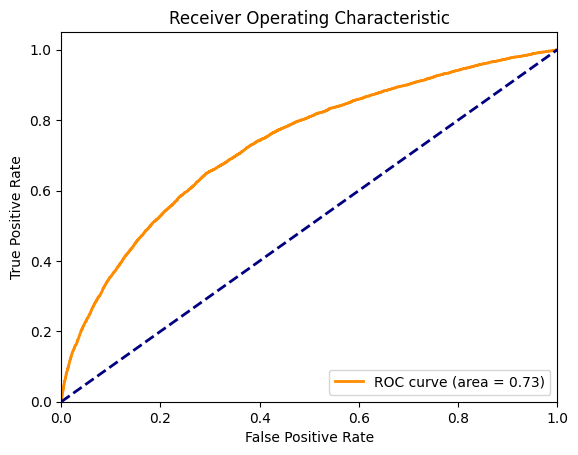

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have collected all_scores and all_labels from your dataset
pairs_labels_file_roc = '/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_train.json'
embeddings_dir_roc = '/project/msoleyma_1026/ecp/data/pair_embeddings/video/train'
train_dataset_roc = PairDataset(pairs_labels_file_roc, embeddings_dir_roc, mode='train')
train_loader_roc = DataLoader(train_dataset_roc, batch_size=batch_size, shuffle=True, collate_fn=debug_collate_fn)
scores, labels = evaluate_model_for_roc(model, train_loader_roc, device)

fpr, tpr, thresholds = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [32]:
# Calculate the optimal threshold: the one with the highest tpr - fpr
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('Optimal threshold:', optimal_threshold)

Optimal threshold: 0.4439260959625244


In [10]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    TP = 0
    FP = 0
    FN = 0
    TN = 0

    with torch.no_grad():
        for batch in dataloader:
            context_embeddings, target_pairs, conversation_ids, utterance_ids = batch
            
            context_embeddings = context_embeddings.to(device)
            target_pairs = target_pairs.to(device)
            # print(f"Target pairs shape: {target_pairs.shape}")
            
            output = model(context_embeddings)
            # print(f"Output shape: {output.shape}")

            target_pairs = target_pairs.squeeze()
            # print(f"Target pairs shape after squeeze(): {target_pairs.shape}")
            
            active_outputs = output[target_pairs != -1]
            # print(f"Active outputs shape: {active_outputs.shape}")
            active_pairs = target_pairs[target_pairs != -1]
            loss = criterion(active_outputs, active_pairs)

            total_loss += loss.item()
            sigmoid_output = torch.sigmoid(active_outputs)
            # print(f"Sigmoid output shape: {sigmoid_output.shape}")

            threshold = optimal_threshold #calculated using ROC
            # threshold = 0.5
            binary_predictions = (sigmoid_output >= threshold).float()
            # print(f"Binary predictions shape: {binary_predictions.shape}")
            # print(f"Target pairs shape: {target_pairs.shape}")
            correct_predictions = (binary_predictions == active_pairs)
            # correct_predictions = correct_predictions[target_pairs != -1]
            
            total_correct += correct_predictions.sum().item()
            total_samples += active_pairs.size(0)

            # Calculate TP, FP, FN
            TP += ((binary_predictions == 1) & (active_pairs == 1)).sum().item()
            FP += ((binary_predictions == 1) & (active_pairs == 0)).sum().item()
            FN += ((binary_predictions == 0) & (active_pairs == 1)).sum().item()
            TN += ((binary_predictions == 0) & (active_pairs == 0)).sum().item()

            # Store conversation and utterance IDs along with predicted emotions
            # for i in range(len(conversation_ids)):
            #     conv_id = conversation_ids[i]
            #     utter_id = utterance_ids[i]
            #     prediction = binary_predictions[i].tolist()
            #     predictions[(conv_id, utter_id)] = tuple(prediction)

    print(f"True Positives: {TP}")
    print(f"False Positives: {FP}")
    print(f"False Negatives: {FN}")
    print(f"True Negatives: {TN}")
    print(f"Total samples: {total_samples}")

    average_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_samples

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return average_loss, accuracy, precision, recall, f1_score

In [34]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pairs_labels_file = '/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_test.json'
embeddings_dir = '/project/msoleyma_1026/ecp/data/pair_embeddings/video/test'

test_dataset = PairDataset(pairs_labels_file, embeddings_dir, mode='eval')

test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=debug_collate_fn)

val_loss, val_accuracy, val_precision, val_recall, val_f1_score = evaluate_model(model, test_dataloader, criterion)
print(f'Test Loss: {val_loss:.4f}, Test Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1_score:.4f}')

True Positives: 1369
False Positives: 3606
False Negatives: 424
True Negatives: 4933
Total samples: 10332
Test Loss: 0.9450, Test Accuracy: 0.6099, Precision: 0.2752, Recall: 0.7635, F1 Score: 0.4046


For pos_w: 4.8


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.1528
Epoch [1/20], Batch [10/17], Loss: 1.1665
Epoch [1/20], Batch [15/17], Loss: 1.1295
Epoch 1/20, Loss: 1.1409
Epoch [2/20], Batch [5/17], Loss: 1.0855
Epoch [2/20], Batch [10/17], Loss: 1.1194
Epoch [2/20], Batch [15/17], Loss: 1.0950
Epoch 2/20, Loss: 1.1168
Epoch [3/20], Batch [5/17], Loss: 1.1550
Epoch [3/20], Batch [10/17], Loss: 1.1694
Epoch [3/20], Batch [15/17], Loss: 1.1136
Epoch 3/20, Loss: 1.1162
Epoch [4/20], Batch [5/17], Loss: 1.0868
Epoch [4/20], Batch [10/17], Loss: 1.1367
Epoch [4/20], Batch [15/17], Loss: 1.0901
Epoch 4/20, Loss: 1.1117
Epoch [5/20], Batch [5/17], Loss: 1.0985
Epoch [5/20], Batch [10/17], Loss: 1.1445
Epoch [5/20], Batch [15/17], Loss: 1.1029
Epoch 5/20, Loss: 1.1094
Epoch [6/20], Batch [5/17], Loss: 1.1697
Epoch [6/20], Batch [10/17], Loss: 1.0914
Epoch [6/20], Batch [15/17], Loss: 1.1217
Epoch 6/20, Loss: 1.1079
Epoch [7/20], Batch [5/17], Loss: 1.1252
Epoch [7/20], Batch [10/17], Loss: 1.0988
Epoch [7/20], Bat

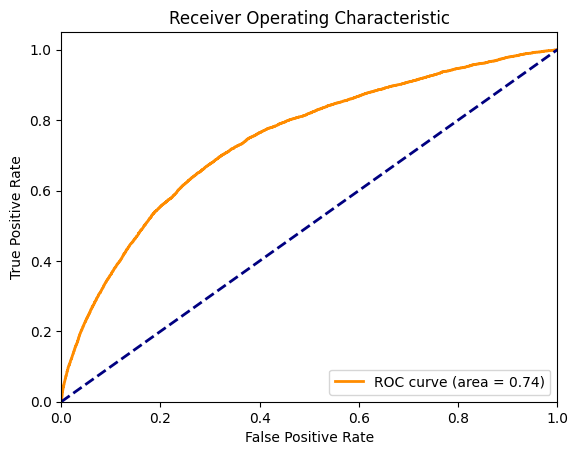

Optimal threshold: 0.43037188053131104
True Positives: 1436
False Positives: 4004
False Negatives: 357
True Negatives: 4535
Total samples: 10332
For pos_weight: 4.8 ---> Test Loss: 1.0156, Test Accuracy: 0.5779, Precision: 0.2640, Recall: 0.8009, F1 Score: 0.3971
For pos_w: 4.7


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.1203
Epoch [1/20], Batch [10/17], Loss: 1.1045
Epoch [1/20], Batch [15/17], Loss: 1.1114
Epoch 1/20, Loss: 1.1272
Epoch [2/20], Batch [5/17], Loss: 1.1463
Epoch [2/20], Batch [10/17], Loss: 1.0912
Epoch [2/20], Batch [15/17], Loss: 1.0388
Epoch 2/20, Loss: 1.1061
Epoch [3/20], Batch [5/17], Loss: 1.1577
Epoch [3/20], Batch [10/17], Loss: 1.1288
Epoch [3/20], Batch [15/17], Loss: 1.0701
Epoch 3/20, Loss: 1.1025
Epoch [4/20], Batch [5/17], Loss: 1.1036
Epoch [4/20], Batch [10/17], Loss: 1.1110
Epoch [4/20], Batch [15/17], Loss: 1.0953
Epoch 4/20, Loss: 1.0984
Epoch [5/20], Batch [5/17], Loss: 1.0939
Epoch [5/20], Batch [10/17], Loss: 1.0839
Epoch [5/20], Batch [15/17], Loss: 1.1187
Epoch 5/20, Loss: 1.0959
Epoch [6/20], Batch [5/17], Loss: 1.1769
Epoch [6/20], Batch [10/17], Loss: 1.1246
Epoch [6/20], Batch [15/17], Loss: 1.0778
Epoch 6/20, Loss: 1.1016
Epoch [7/20], Batch [5/17], Loss: 1.0821
Epoch [7/20], Batch [10/17], Loss: 1.0656
Epoch [7/20], Bat

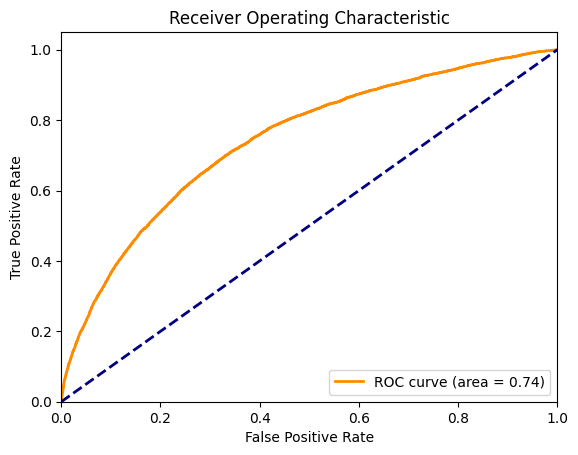

Optimal threshold: 0.5073260068893433
True Positives: 1443
False Positives: 4352
False Negatives: 350
True Negatives: 4187
Total samples: 10332
For pos_weight: 4.7 ---> Test Loss: 1.0264, Test Accuracy: 0.5449, Precision: 0.2490, Recall: 0.8048, F1 Score: 0.3803
For pos_w: 4.6


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.1758
Epoch [1/20], Batch [10/17], Loss: 1.1449
Epoch [1/20], Batch [15/17], Loss: 1.1578
Epoch 1/20, Loss: 1.1465
Epoch [2/20], Batch [5/17], Loss: 1.0884
Epoch [2/20], Batch [10/17], Loss: 1.1803
Epoch [2/20], Batch [15/17], Loss: 1.0664
Epoch 2/20, Loss: 1.1016
Epoch [3/20], Batch [5/17], Loss: 1.1381
Epoch [3/20], Batch [10/17], Loss: 1.0730
Epoch [3/20], Batch [15/17], Loss: 1.1529
Epoch 3/20, Loss: 1.0966
Epoch [4/20], Batch [5/17], Loss: 1.1005
Epoch [4/20], Batch [10/17], Loss: 1.0689
Epoch [4/20], Batch [15/17], Loss: 1.1498
Epoch 4/20, Loss: 1.0918
Epoch [5/20], Batch [5/17], Loss: 1.0554
Epoch [5/20], Batch [10/17], Loss: 1.1177
Epoch [5/20], Batch [15/17], Loss: 1.0970
Epoch 5/20, Loss: 1.0876
Epoch [6/20], Batch [5/17], Loss: 1.1338
Epoch [6/20], Batch [10/17], Loss: 1.0711
Epoch [6/20], Batch [15/17], Loss: 1.0392
Epoch 6/20, Loss: 1.0850
Epoch [7/20], Batch [5/17], Loss: 1.0411
Epoch [7/20], Batch [10/17], Loss: 1.1185
Epoch [7/20], Bat

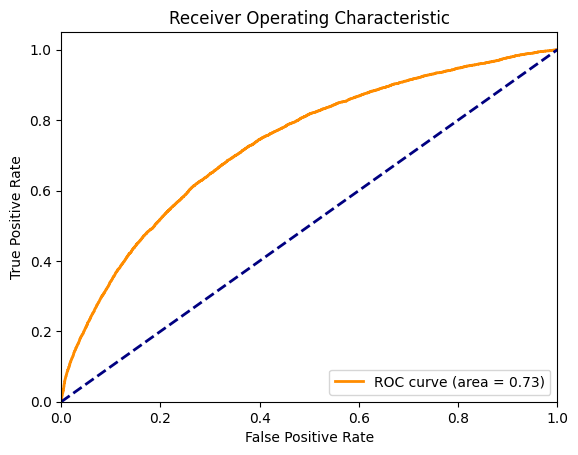

Optimal threshold: 0.4997146427631378
True Positives: 1495
False Positives: 4737
False Negatives: 298
True Negatives: 3802
Total samples: 10332
For pos_weight: 4.6 ---> Test Loss: 1.0270, Test Accuracy: 0.5127, Precision: 0.2399, Recall: 0.8338, F1 Score: 0.3726
For pos_w: 4.5


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.0832
Epoch [1/20], Batch [10/17], Loss: 1.0927
Epoch [1/20], Batch [15/17], Loss: 1.1020
Epoch 1/20, Loss: 1.1056
Epoch [2/20], Batch [5/17], Loss: 1.0928
Epoch [2/20], Batch [10/17], Loss: 1.1175
Epoch [2/20], Batch [15/17], Loss: 1.0591
Epoch 2/20, Loss: 1.0869
Epoch [3/20], Batch [5/17], Loss: 1.0807
Epoch [3/20], Batch [10/17], Loss: 1.1174
Epoch [3/20], Batch [15/17], Loss: 1.0562
Epoch 3/20, Loss: 1.0768
Epoch [4/20], Batch [5/17], Loss: 1.0816
Epoch [4/20], Batch [10/17], Loss: 1.1111
Epoch [4/20], Batch [15/17], Loss: 1.0316
Epoch 4/20, Loss: 1.0784
Epoch [5/20], Batch [5/17], Loss: 1.0364
Epoch [5/20], Batch [10/17], Loss: 1.0745
Epoch [5/20], Batch [15/17], Loss: 1.0931
Epoch 5/20, Loss: 1.0735
Epoch [6/20], Batch [5/17], Loss: 1.0063
Epoch [6/20], Batch [10/17], Loss: 1.0863
Epoch [6/20], Batch [15/17], Loss: 1.0990
Epoch 6/20, Loss: 1.0769
Epoch [7/20], Batch [5/17], Loss: 1.0665
Epoch [7/20], Batch [10/17], Loss: 1.0727
Epoch [7/20], Bat

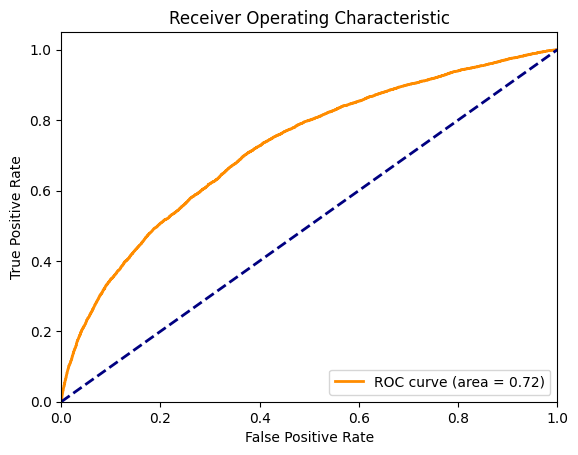

Optimal threshold: 0.4153774678707123
True Positives: 1460
False Positives: 4689
False Negatives: 333
True Negatives: 3850
Total samples: 10332
For pos_weight: 4.5 ---> Test Loss: 0.9955, Test Accuracy: 0.5139, Precision: 0.2374, Recall: 0.8143, F1 Score: 0.3677
For pos_w: 4.4


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.1150
Epoch [1/20], Batch [10/17], Loss: 1.1009
Epoch [1/20], Batch [15/17], Loss: 1.0998
Epoch 1/20, Loss: 1.1050
Epoch [2/20], Batch [5/17], Loss: 1.0825
Epoch [2/20], Batch [10/17], Loss: 1.0926
Epoch [2/20], Batch [15/17], Loss: 1.0476
Epoch 2/20, Loss: 1.0734
Epoch [3/20], Batch [5/17], Loss: 1.0181
Epoch [3/20], Batch [10/17], Loss: 1.0669
Epoch [3/20], Batch [15/17], Loss: 1.1323
Epoch 3/20, Loss: 1.0631
Epoch [4/20], Batch [5/17], Loss: 1.0559
Epoch [4/20], Batch [10/17], Loss: 1.1199
Epoch [4/20], Batch [15/17], Loss: 1.0403
Epoch 4/20, Loss: 1.0643
Epoch [5/20], Batch [5/17], Loss: 1.0047
Epoch [5/20], Batch [10/17], Loss: 1.0104
Epoch [5/20], Batch [15/17], Loss: 1.0465
Epoch 5/20, Loss: 1.0628
Epoch [6/20], Batch [5/17], Loss: 1.0391
Epoch [6/20], Batch [10/17], Loss: 1.0130
Epoch [6/20], Batch [15/17], Loss: 1.0338
Epoch 6/20, Loss: 1.0608
Epoch [7/20], Batch [5/17], Loss: 1.0676
Epoch [7/20], Batch [10/17], Loss: 1.0445
Epoch [7/20], Bat

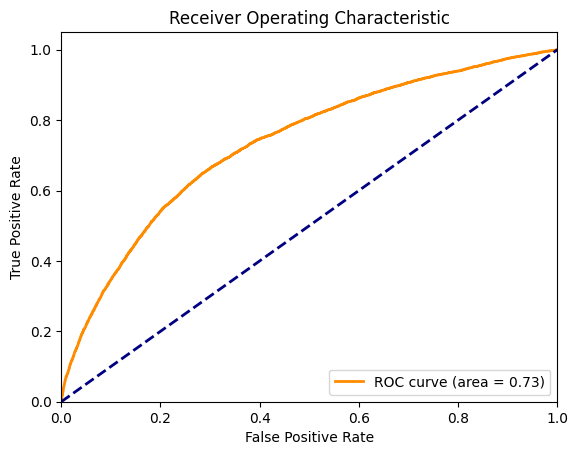

Optimal threshold: 0.4537523090839386
True Positives: 1411
False Positives: 4027
False Negatives: 382
True Negatives: 4512
Total samples: 10332
For pos_weight: 4.4 ---> Test Loss: 0.9896, Test Accuracy: 0.5733, Precision: 0.2595, Recall: 0.7869, F1 Score: 0.3903
For pos_w: 4.3


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.0584
Epoch [1/20], Batch [10/17], Loss: 1.0765
Epoch [1/20], Batch [15/17], Loss: 1.1010
Epoch 1/20, Loss: 1.0808
Epoch [2/20], Batch [5/17], Loss: 1.0501
Epoch [2/20], Batch [10/17], Loss: 1.0387
Epoch [2/20], Batch [15/17], Loss: 1.0828
Epoch 2/20, Loss: 1.0575
Epoch [3/20], Batch [5/17], Loss: 1.0315
Epoch [3/20], Batch [10/17], Loss: 1.0813
Epoch [3/20], Batch [15/17], Loss: 1.0258
Epoch 3/20, Loss: 1.0550
Epoch [4/20], Batch [5/17], Loss: 1.0472
Epoch [4/20], Batch [10/17], Loss: 1.0042
Epoch [4/20], Batch [15/17], Loss: 1.0829
Epoch 4/20, Loss: 1.0528
Epoch [5/20], Batch [5/17], Loss: 1.0771
Epoch [5/20], Batch [10/17], Loss: 1.0515
Epoch [5/20], Batch [15/17], Loss: 1.0134
Epoch 5/20, Loss: 1.0477
Epoch [6/20], Batch [5/17], Loss: 1.0489
Epoch [6/20], Batch [10/17], Loss: 1.0780
Epoch [6/20], Batch [15/17], Loss: 1.0198
Epoch 6/20, Loss: 1.0513
Epoch [7/20], Batch [5/17], Loss: 1.0694
Epoch [7/20], Batch [10/17], Loss: 1.0808
Epoch [7/20], Bat

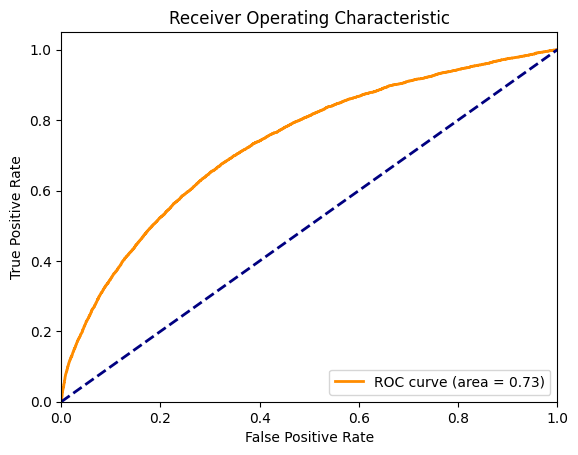

Optimal threshold: 0.4769550859928131
True Positives: 1491
False Positives: 4659
False Negatives: 302
True Negatives: 3880
Total samples: 10332
For pos_weight: 4.3 ---> Test Loss: 0.9846, Test Accuracy: 0.5198, Precision: 0.2424, Recall: 0.8316, F1 Score: 0.3754
For pos_w: 4.2


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.0267
Epoch [1/20], Batch [10/17], Loss: 1.0730
Epoch [1/20], Batch [15/17], Loss: 1.0495
Epoch 1/20, Loss: 1.0600
Epoch [2/20], Batch [5/17], Loss: 0.9737
Epoch [2/20], Batch [10/17], Loss: 1.0346
Epoch [2/20], Batch [15/17], Loss: 1.0215
Epoch 2/20, Loss: 1.0436
Epoch [3/20], Batch [5/17], Loss: 1.0183
Epoch [3/20], Batch [10/17], Loss: 0.9931
Epoch [3/20], Batch [15/17], Loss: 1.0321
Epoch 3/20, Loss: 1.0455
Epoch [4/20], Batch [5/17], Loss: 0.9899
Epoch [4/20], Batch [10/17], Loss: 1.0509
Epoch [4/20], Batch [15/17], Loss: 0.9767
Epoch 4/20, Loss: 1.0429
Epoch [5/20], Batch [5/17], Loss: 0.9877
Epoch [5/20], Batch [10/17], Loss: 0.9991
Epoch [5/20], Batch [15/17], Loss: 1.0672
Epoch 5/20, Loss: 1.0411
Epoch [6/20], Batch [5/17], Loss: 1.0351
Epoch [6/20], Batch [10/17], Loss: 1.0350
Epoch [6/20], Batch [15/17], Loss: 1.0082
Epoch 6/20, Loss: 1.0379
Epoch [7/20], Batch [5/17], Loss: 1.0001
Epoch [7/20], Batch [10/17], Loss: 1.0292
Epoch [7/20], Bat

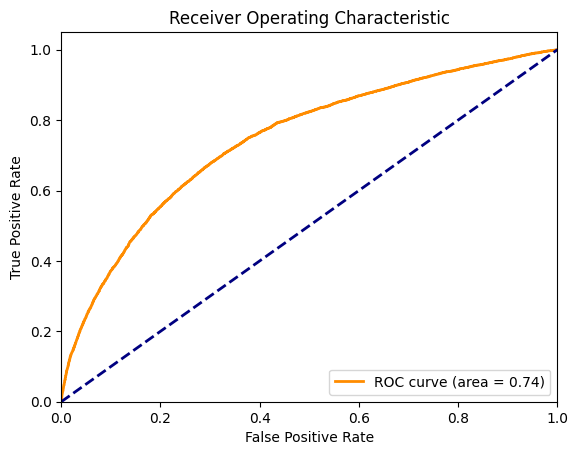

Optimal threshold: 0.43523645401000977
True Positives: 1394
False Positives: 3820
False Negatives: 399
True Negatives: 4719
Total samples: 10332
For pos_weight: 4.2 ---> Test Loss: 0.9545, Test Accuracy: 0.5917, Precision: 0.2674, Recall: 0.7775, F1 Score: 0.3979
For pos_w: 4.1


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.0703
Epoch [1/20], Batch [10/17], Loss: 1.0261
Epoch [1/20], Batch [15/17], Loss: 1.0160
Epoch 1/20, Loss: 1.0745
Epoch [2/20], Batch [5/17], Loss: 1.0217
Epoch [2/20], Batch [10/17], Loss: 1.0302
Epoch [2/20], Batch [15/17], Loss: 1.0592
Epoch 2/20, Loss: 1.0323
Epoch [3/20], Batch [5/17], Loss: 1.0048
Epoch [3/20], Batch [10/17], Loss: 1.0501
Epoch [3/20], Batch [15/17], Loss: 1.0259
Epoch 3/20, Loss: 1.0314
Epoch [4/20], Batch [5/17], Loss: 1.0049
Epoch [4/20], Batch [10/17], Loss: 1.0112
Epoch [4/20], Batch [15/17], Loss: 1.0058
Epoch 4/20, Loss: 1.0293
Epoch [5/20], Batch [5/17], Loss: 1.0120
Epoch [5/20], Batch [10/17], Loss: 1.0014
Epoch [5/20], Batch [15/17], Loss: 0.9855
Epoch 5/20, Loss: 1.0298
Epoch [6/20], Batch [5/17], Loss: 1.0157
Epoch [6/20], Batch [10/17], Loss: 1.0491
Epoch [6/20], Batch [15/17], Loss: 1.0023
Epoch 6/20, Loss: 1.0270
Epoch [7/20], Batch [5/17], Loss: 1.0199
Epoch [7/20], Batch [10/17], Loss: 0.9884
Epoch [7/20], Bat

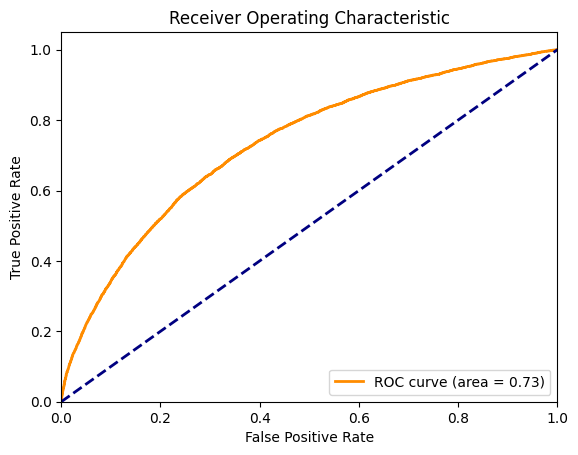

Optimal threshold: 0.4816366732120514
True Positives: 1493
False Positives: 4670
False Negatives: 300
True Negatives: 3869
Total samples: 10332
For pos_weight: 4.1 ---> Test Loss: 0.9736, Test Accuracy: 0.5190, Precision: 0.2423, Recall: 0.8327, F1 Score: 0.3753
For pos_w: 4.0


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.0621
Epoch [1/20], Batch [10/17], Loss: 0.9870
Epoch [1/20], Batch [15/17], Loss: 0.9878
Epoch 1/20, Loss: 1.0363
Epoch [2/20], Batch [5/17], Loss: 0.9881
Epoch [2/20], Batch [10/17], Loss: 1.0008
Epoch [2/20], Batch [15/17], Loss: 1.0450
Epoch 2/20, Loss: 1.0177
Epoch [3/20], Batch [5/17], Loss: 1.0098
Epoch [3/20], Batch [10/17], Loss: 1.0084
Epoch [3/20], Batch [15/17], Loss: 0.9822
Epoch 3/20, Loss: 1.0154
Epoch [4/20], Batch [5/17], Loss: 1.0121
Epoch [4/20], Batch [10/17], Loss: 1.0230
Epoch [4/20], Batch [15/17], Loss: 0.9953
Epoch 4/20, Loss: 1.0135
Epoch [5/20], Batch [5/17], Loss: 1.0135
Epoch [5/20], Batch [10/17], Loss: 0.9934
Epoch [5/20], Batch [15/17], Loss: 0.9911
Epoch 5/20, Loss: 1.0110
Epoch [6/20], Batch [5/17], Loss: 1.0227
Epoch [6/20], Batch [10/17], Loss: 1.0086
Epoch [6/20], Batch [15/17], Loss: 0.9766
Epoch 6/20, Loss: 1.0068
Epoch [7/20], Batch [5/17], Loss: 0.9671
Epoch [7/20], Batch [10/17], Loss: 1.0289
Epoch [7/20], Bat

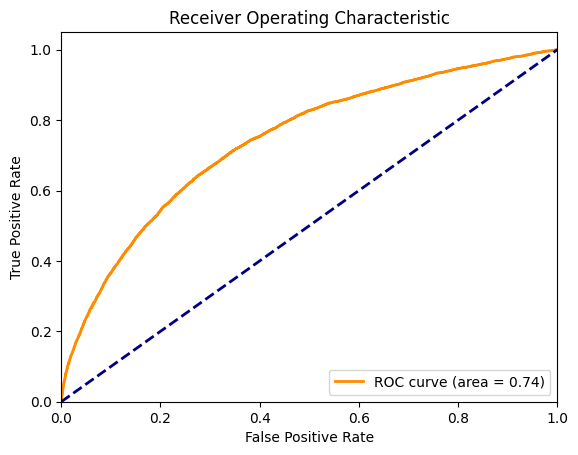

Optimal threshold: 0.4559387266635895
True Positives: 1493
False Positives: 4671
False Negatives: 300
True Negatives: 3868
Total samples: 10332
For pos_weight: 4.0 ---> Test Loss: 0.9567, Test Accuracy: 0.5189, Precision: 0.2422, Recall: 0.8327, F1 Score: 0.3753


In [13]:
pos_ws = [4.8, 4.7, 4.6, 4.5, 4.4, 4.3, 4.2, 4.1, 4.0]
for pos_w in pos_ws:   
    print(f"For pos_w: {pos_w}") 
    input_size = 1543
    hidden_size = 1024
    num_classes = 1
    lr = 1e-5
    batch_size = 64
    num_epochs = 20
    num_layers = 4
    print_interval = 5

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    pairs_labels_file = '/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_train.json'
    embeddings_dir = '/project/msoleyma_1026/ecp/data/pair_embeddings/video/train'

    train_dataset = PairDataset(pairs_labels_file, embeddings_dir, mode='train')

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=debug_collate_fn)

    model = PairDetector(input_size, hidden_size, num_classes, n_layers=num_layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_w).float()) 

    total_loss = 0.0
    total_batches = 0

    for epoch in range(num_epochs):
        model.train()
        epoch_loss_emotion = 0.0
        num_batches = 0
        for batch_idx, (inputs, labels, convID, utterancePairs) in enumerate(train_loader):
            inputs = inputs.float()
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = labels.squeeze()

            active_outputs = outputs[labels != -1]
            active_pairs = labels[labels != -1]
            loss = criterion(active_outputs, active_pairs)
            loss.backward()
            optimizer.step()

            epoch_loss_emotion += loss.item()
            total_loss += loss.item()
            total_batches += 1
            # print(loss.item())

            if (batch_idx + 1) % print_interval == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], '
                    f'Loss: {loss.item():.4f}')

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss_emotion / len(train_loader):.4f}")

    overall_avg_loss = total_loss / total_batches
    print(f"Overall Average Training Loss: {overall_avg_loss:.4f}")

    torch.save(model.state_dict(), '/project/msoleyma_1026/ecp/models/pair_detection_model_late_video.pt')

    
    scores, labels = evaluate_model_for_roc(model, train_loader_roc, device)

    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Calculate the optimal threshold: the one with the highest tpr - fpr
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print('Optimal threshold:', optimal_threshold)

    def evaluate_model(model, dataloader, criterion):
        model.eval()
        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        TP = 0
        FP = 0
        FN = 0
        TN = 0

        with torch.no_grad():
            for batch in dataloader:
                context_embeddings, target_pairs, conversation_ids, utterance_ids = batch
                
                context_embeddings = context_embeddings.to(device)
                target_pairs = target_pairs.to(device)

                output = model(context_embeddings)

                target_pairs = target_pairs.squeeze()

                active_outputs = output[target_pairs != -1]
                active_pairs = target_pairs[target_pairs != -1]
                loss = criterion(active_outputs, active_pairs)

                total_loss += loss.item()
                sigmoid_output = torch.sigmoid(active_outputs)

                threshold = optimal_threshold #calculated using ROC
                # threshold = 0.5
                binary_predictions = (sigmoid_output >= threshold).float()

                correct_predictions = (binary_predictions == active_pairs)
                # correct_predictions = correct_predictions[target_pairs != -1]
                
                total_correct += correct_predictions.sum().item()
                total_samples += active_pairs.size(0)

                # Calculate TP, FP, FN
                TP += ((binary_predictions == 1) & (active_pairs == 1)).sum().item()
                FP += ((binary_predictions == 1) & (active_pairs == 0)).sum().item()
                FN += ((binary_predictions == 0) & (active_pairs == 1)).sum().item()
                TN += ((binary_predictions == 0) & (active_pairs == 0)).sum().item()

                # Store conversation and utterance IDs along with predicted emotions
                # for i in range(len(conversation_ids)):
                #     conv_id = conversation_ids[i]
                #     utter_id = utterance_ids[i]
                #     prediction = binary_predictions[i].tolist()
                #     predictions[(conv_id, utter_id)] = tuple(prediction)

        print(f"True Positives: {TP}")
        print(f"False Positives: {FP}")
        print(f"False Negatives: {FN}")
        print(f"True Negatives: {TN}")
        print(f"Total samples: {total_samples}")

        average_loss = total_loss / len(dataloader)
        accuracy = total_correct / total_samples

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        return average_loss, accuracy, precision, recall, f1_score

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    pairs_labels_file = '/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_test.json'
    embeddings_dir = '/project/msoleyma_1026/ecp/data/pair_embeddings/video/test'

    test_dataset = PairDataset(pairs_labels_file, embeddings_dir, mode='eval')

    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=debug_collate_fn)

    val_loss, val_accuracy, val_precision, val_recall, val_f1_score = evaluate_model(model, test_dataloader, criterion)
    print(f'For pos_weight: {pos_w} ---> Test Loss: {val_loss:.4f}, Test Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1_score:.4f}')